In [1]:
import pandas as pd
import numpy as np
from category_encoders import LeaveOneOutEncoder
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, TweedieRegressor, Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import seaborn as sns
from sklearn.preprocessing import (
    OneHotEncoder,
    PolynomialFeatures,
    MinMaxScaler,
    StandardScaler,
    RobustScaler,
    PowerTransformer,
    QuantileTransformer,
)
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from scipy.stats import ttest_ind
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.ensemble import HistGradientBoostingRegressor

In [2]:
df = pd.read_csv('car_price_prediction.csv')

# Очистка данных(Edit)

In [3]:
# поиск и удаление дубликатов
duplicate_rows = df[df.duplicated()]
print(len(duplicate_rows))
df = df.drop_duplicates()

313


In [4]:
df = df.drop(columns=['ID'])

In [5]:
def mileage_to_int(x: str) -> int:
    return int(x.replace(" km", ""))
df["Mileage"] = df["Mileage"].apply(mileage_to_int)

In [6]:
df["Levy"] = df["Levy"].replace("-", 0)
df = df.astype({"Levy": "int32"})

In [7]:
df.loc[df["Manufacturer"] == "სხვა", "Manufacturer"] = df["Model"].apply(lambda x: x.split(" ")[0])

In [8]:
def has_turbo(x: str) -> bool:
    return "Turbo" in x
    
def engine_volume_to_float(x: str) -> float:
    return float(x.replace(" Turbo", ""))

df["Turbo"] = df["Engine volume"].apply(has_turbo)
df["Engine volume"] = df["Engine volume"].apply(engine_volume_to_float)

In [9]:
df = df.astype({"Cylinders": "int32"})

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18924 entries, 0 to 19236
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Price             18924 non-null  int64  
 1   Levy              18924 non-null  int32  
 2   Manufacturer      18924 non-null  object 
 3   Model             18924 non-null  object 
 4   Prod. year        18924 non-null  int64  
 5   Category          18924 non-null  object 
 6   Leather interior  18924 non-null  object 
 7   Fuel type         18924 non-null  object 
 8   Engine volume     18924 non-null  float64
 9   Mileage           18924 non-null  int64  
 10  Cylinders         18924 non-null  int32  
 11  Gear box type     18924 non-null  object 
 12  Drive wheels      18924 non-null  object 
 13  Doors             18924 non-null  object 
 14  Wheel             18924 non-null  object 
 15  Color             18924 non-null  object 
 16  Airbags           18924 non-null  int64  
 17

# Первичный анализ признаков

In [11]:
translations = {
    'Price' : 'Цена',
    'Prod. year' : 'Дата производства',
}

def eda_visualize(column, xlim=None):
    xlabel = translations.get(column.name, column.name)
    fig, axes = plt.subplots(1, 2, figsize=(16,6))
    sns.histplot(column, ax=axes[0], bins=25, kde=False)
    axes[0].set(title='Гистограмма', xlabel=xlabel, ylabel='Наблюдений, шт.', xlim=xlim)
    sns.violinplot(column, ax=axes[1], orient='h')
    axes[1].set(title='Плотность и размах', xlabel=xlabel, xlim=xlim)

def price_by_category(df_, group_by, figsize=(24,6)):
    fig, axes = plt.subplots(1, 2, figsize=figsize)
    df_.groupby(group_by)["Price"].mean().sort_values().plot(kind="bar", ax=axes[0], title='Средние')
    df_.groupby(group_by)["Price"].median().sort_values().plot(kind="bar", ax=axes[1], title='Медианы')
    return df_.groupby(group_by)["Price"].agg(['mean', 'median', "count"])

## Численные(Read only)

### Price: целевой, непрерывный

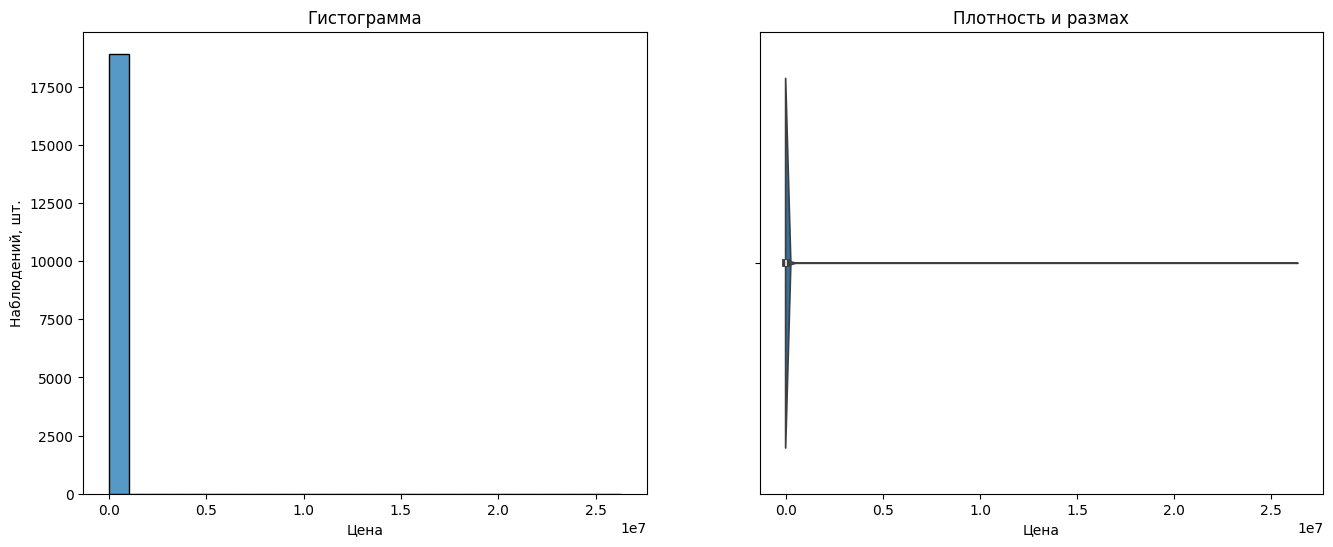

In [12]:
eda_visualize(df["Price"])

### Levy: непрерывный

Levy перевод - сбор. Похоже на какой-то налог.

По информации с kaggle: "Tax of importing and exporting the cars."
Так же указано, что не определена валюта и смысл для "-".

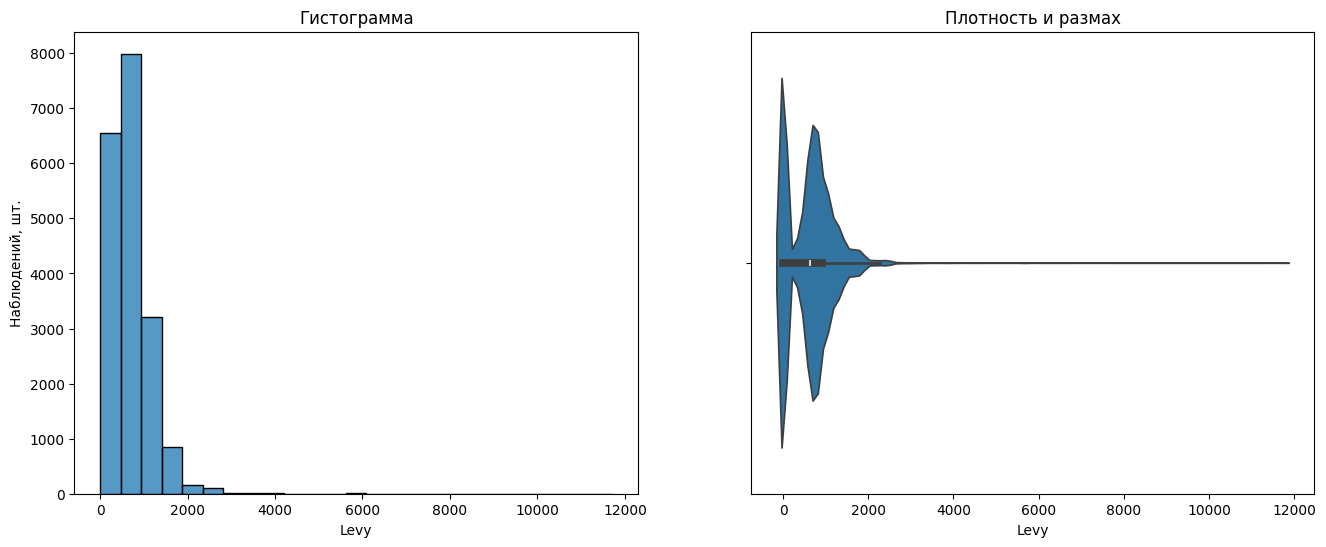

In [13]:
eda_visualize(df["Levy"]);

### Prod. year: численный дискреный

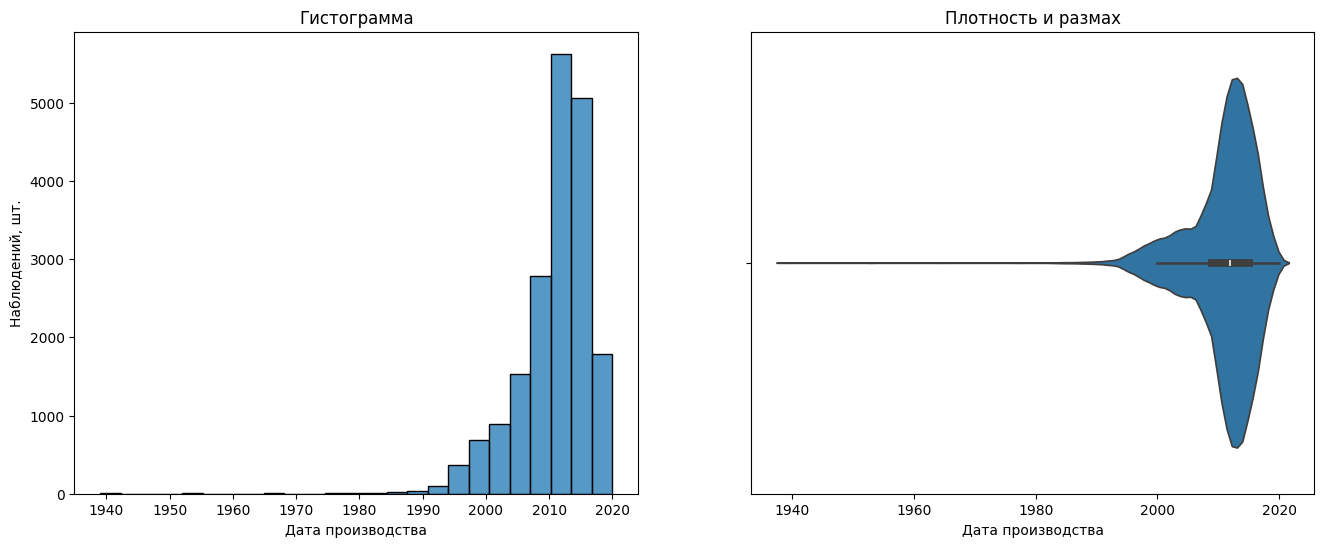

In [14]:
eda_visualize(df["Prod. year"]);

### Engine volume: дискретный

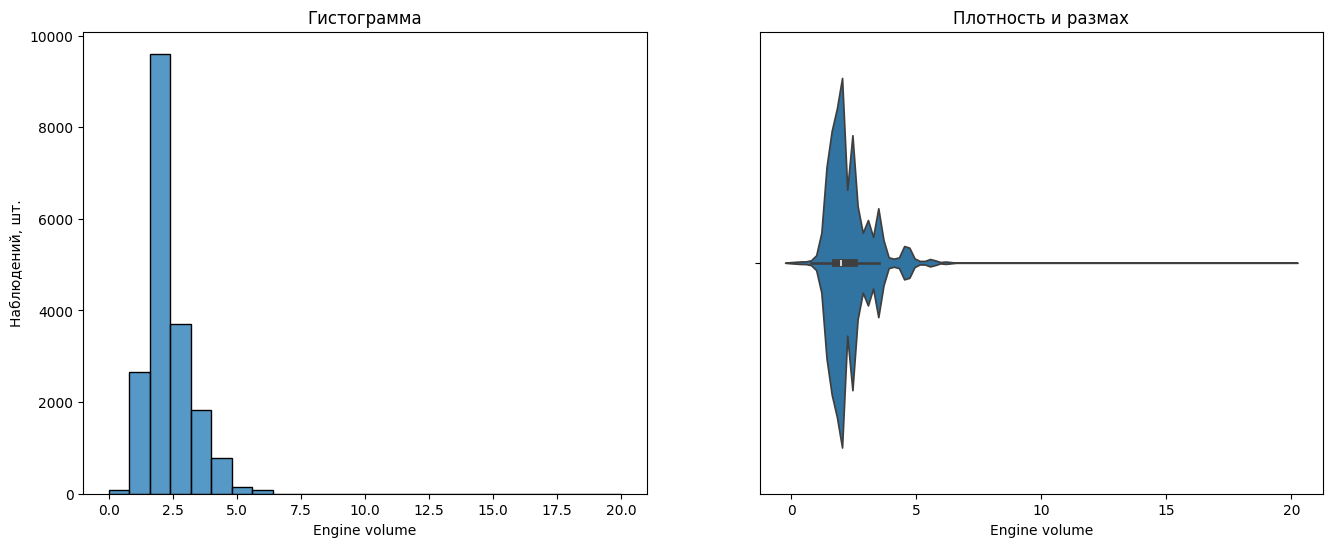

In [15]:
eda_visualize(df["Engine volume"])

### Mileage: непрерывный

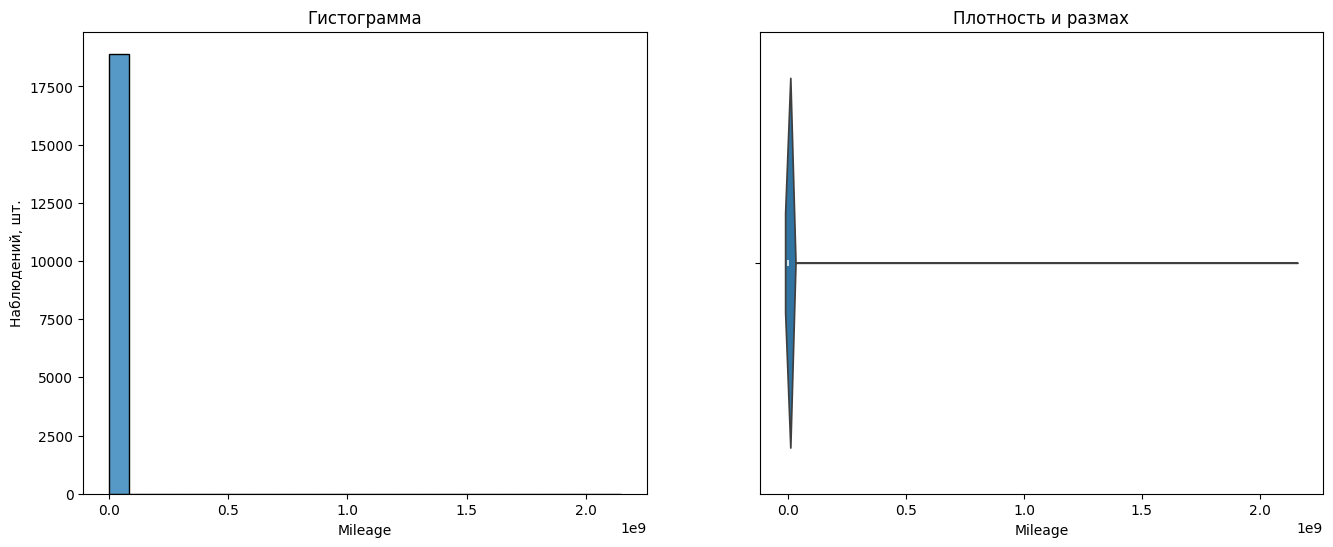

In [16]:
eda_visualize(df["Mileage"])

### Cylinders: дискретный

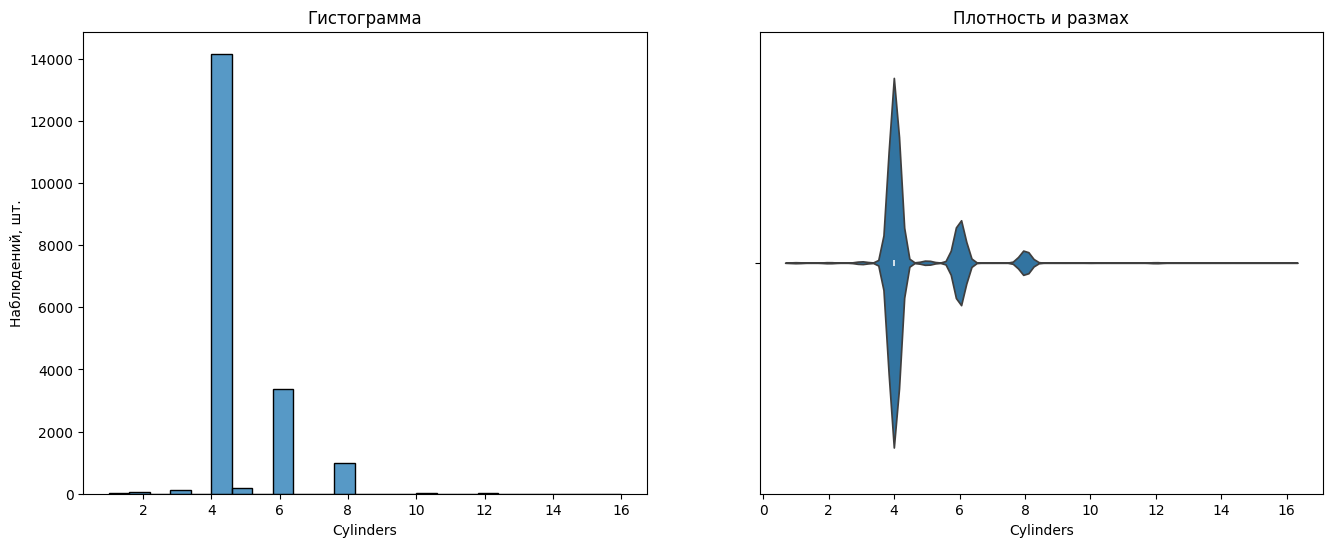

In [17]:
eda_visualize(df["Cylinders"])

### Airbags: дискретный

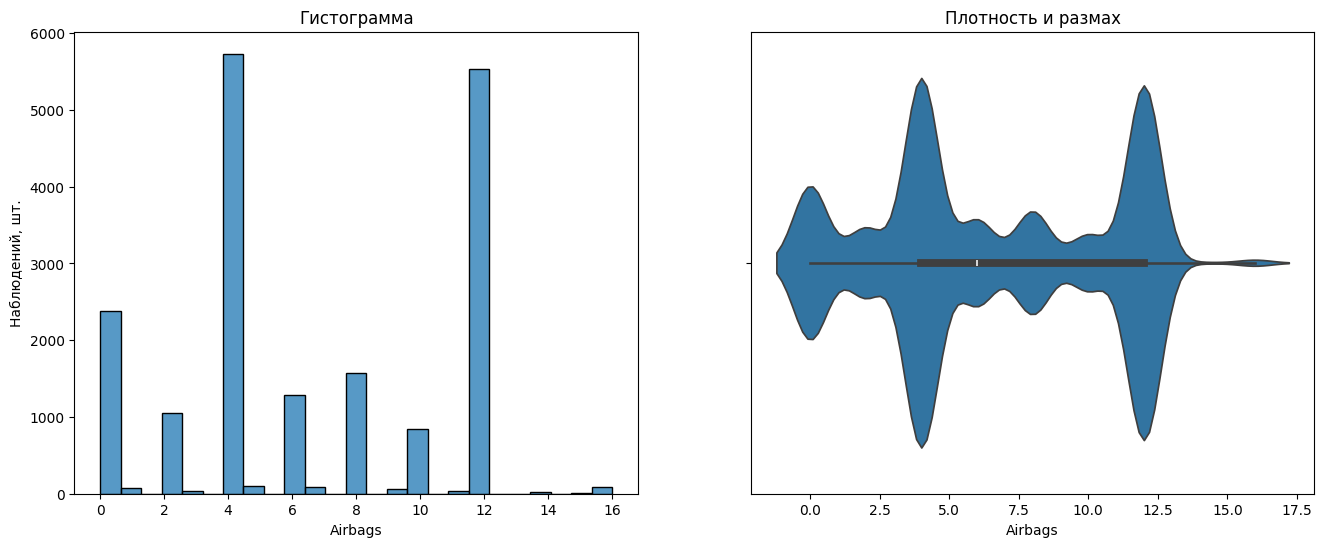

In [18]:
eda_visualize(df["Airbags"])

## Очистка выбросов(Edit)

### Price

In [19]:
df["Price"].sort_values(ascending=True).tail(20)

2912       172486
6468       172486
2768       172486
9248       172486
4722       175622
13328      193184
1145       194438
7353       216391
2283       219527
7283       228935
15283      250574
5840       254024
10759      260296
7749       288521
9367       297930
14839      297930
5008       308906
1225       627220
8541       872946
16983    26307500
Name: Price, dtype: int64

In [20]:
# Смотрим количество машин в группах по 100к
(
    len(df[df.Price <= 100000]),
    len(df[(df.Price > 100000) & (df.Price <= 200000)]),
    len(df[df.Price > 200000]),
)

(18813, 98, 13)

In [21]:
#Для начала отбросим все свыше 100к
df = df[(df.Price < 100000)]

In [22]:
(
    len(df[df.Price <= 1000]),
    len(df[(df.Price > 1000) & (df.Price <= 2000)]),
    len(df[(df.Price > 2000) & (df.Price <= 3000)]),
    len(df[(df.Price > 3000) & (df.Price <= 4000)]),
    len(df[(df.Price > 4000) & (df.Price <= 5000)]),
    len(df[(df.Price > 5000) & (df.Price <= 6000)]),
    len(df[(df.Price > 6000) & (df.Price <= 7000)]),
    len(df[(df.Price > 7000) & (df.Price <= 8000)]),
    len(df[(df.Price > 8000) & (df.Price <= 9000)]),
    len(df[(df.Price > 10000) & (df.Price <= 11000)]),
)

(2529, 622, 431, 509, 448, 540, 526, 677, 554, 783)

Значения меньше 1000 являются выбросом с количественной точки зрения.
Может создать отдельную модель для значений меньше 1000?
Посмотрим эту тысячу по сотням.

In [23]:
(
    len(df[df.Price <= 100]),
    len(df[(df.Price > 100) & (df.Price <= 200)]),
    len(df[(df.Price > 200) & (df.Price <= 300)]),
    len(df[(df.Price > 300) & (df.Price <= 400)]),
    len(df[(df.Price > 400) & (df.Price <= 500)]),
    len(df[(df.Price > 500) & (df.Price <= 600)]),
    len(df[(df.Price > 600) & (df.Price <= 700)]),
    len(df[(df.Price > 700) & (df.Price <= 800)]),
    len(df[(df.Price > 800) & (df.Price <= 900)]),
    len(df[(df.Price > 1000) & (df.Price <= 1100)]),
)

(374, 277, 237, 479, 268, 177, 191, 268, 120, 125)

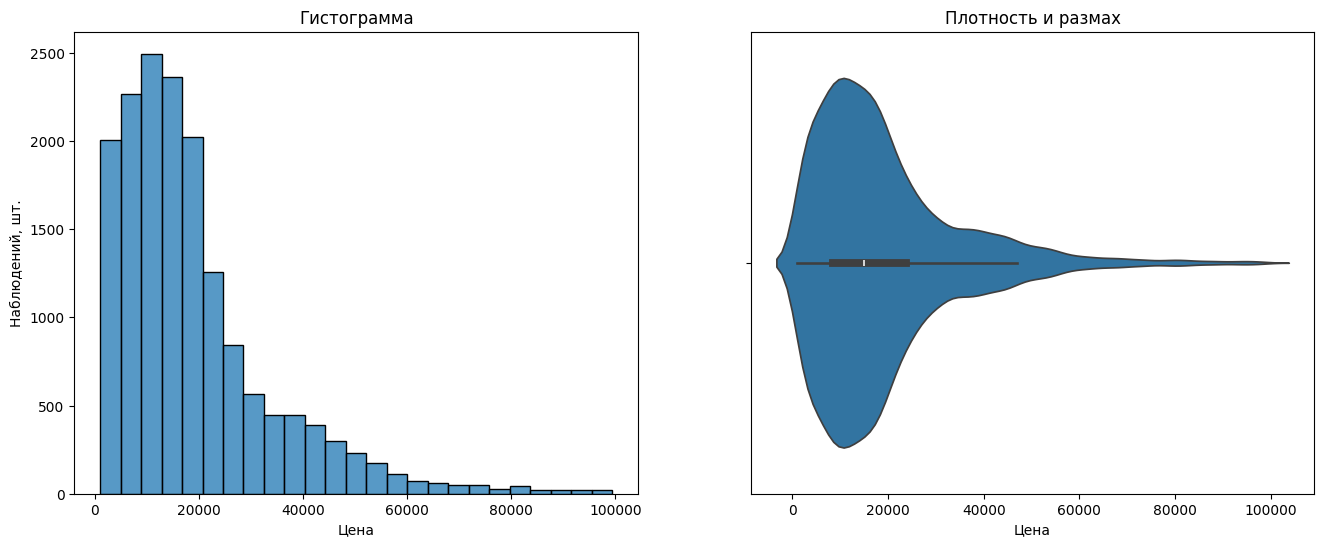

In [24]:
#Аналогично отбросим все ниже 1000
df = df[(df.Price >= 1000)]
eda_visualize(df["Price"])

### Else

In [25]:
# df = df[df["Prod. year"] >= 1990]

In [26]:
# eda_visualize(df["Prod. year"]);

In [27]:
# List of columns to check for outliers
columns_to_check = ['Levy', "Prod. year", 'Engine volume', 'Mileage','Cylinders'] # Not including Airbags since distro seems normal

# Dictionary to store outlier counts
outlier_counts = {}

# Function to remove outliers using IQR
def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1

    # Define the threshold for outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Find and count outliers
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    outlier_count = outliers.shape[0]

    # Remove outliers from the DataFrame
    df_cleaned = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

    return df_cleaned, outlier_count

# Iterate over columns, remove outliers, and store counts
for column in columns_to_check:
    df, count = remove_outliers_iqr(df, column)
    outlier_counts[column] = count

# Display outlier counts
print("Outlier Counts:")
for column, count in outlier_counts.items():
    print(f"{column}: {count}")

Outlier Counts:
Levy: 98
Prod. year: 927
Engine volume: 905
Mileage: 546
Cylinders: 2509


## Категориальные(Read only)

### Manufacturer(66)

In [28]:
df["Manufacturer"].value_counts()

Manufacturer
HYUNDAI          3149
TOYOTA           2389
CHEVROLET         872
HONDA             709
FORD              708
SSANGYONG         435
NISSAN            417
MERCEDES-BENZ     404
KIA               349
VOLKSWAGEN        318
SUBARU            200
OPEL              185
MITSUBISHI        162
LEXUS             154
BMW               152
MAZDA             112
DAEWOO             90
AUDI               79
JEEP               73
FIAT               65
SUZUKI             42
MINI               37
DODGE              34
RENAULT            29
SKODA              16
JAGUAR             15
PEUGEOT            13
VAZ                11
BUICK              11
CITROEN             9
GMC                 8
LAND ROVER          8
CHRYSLER            8
SCION               7
CADILLAC            4
LINCOLN             4
DAIHATSU            4
VOLVO               3
MERCURY             3
INFINITI            3
ALFA ROMEO          3
ACURA               3
SEAT                2
PORSCHE             2
HAVAL              

,mean,median,count
Manufacturer,,,
ACURA,3502.000000,3450.0,3
ALFA ROMEO,11687.000000,12544.0,3
AUDI,15330.341772,13172.0,79
BMW,24995.986842,24462.0,152
BUICK,14528.727273,7056.0,11
CADILLAC,7056.250000,5645.0,4
CHEVROLET,16155.959862,14360.0,872
CHRYSLER,8418.625000,6272.0,8
CITROEN,10640.444444,7840.0,9


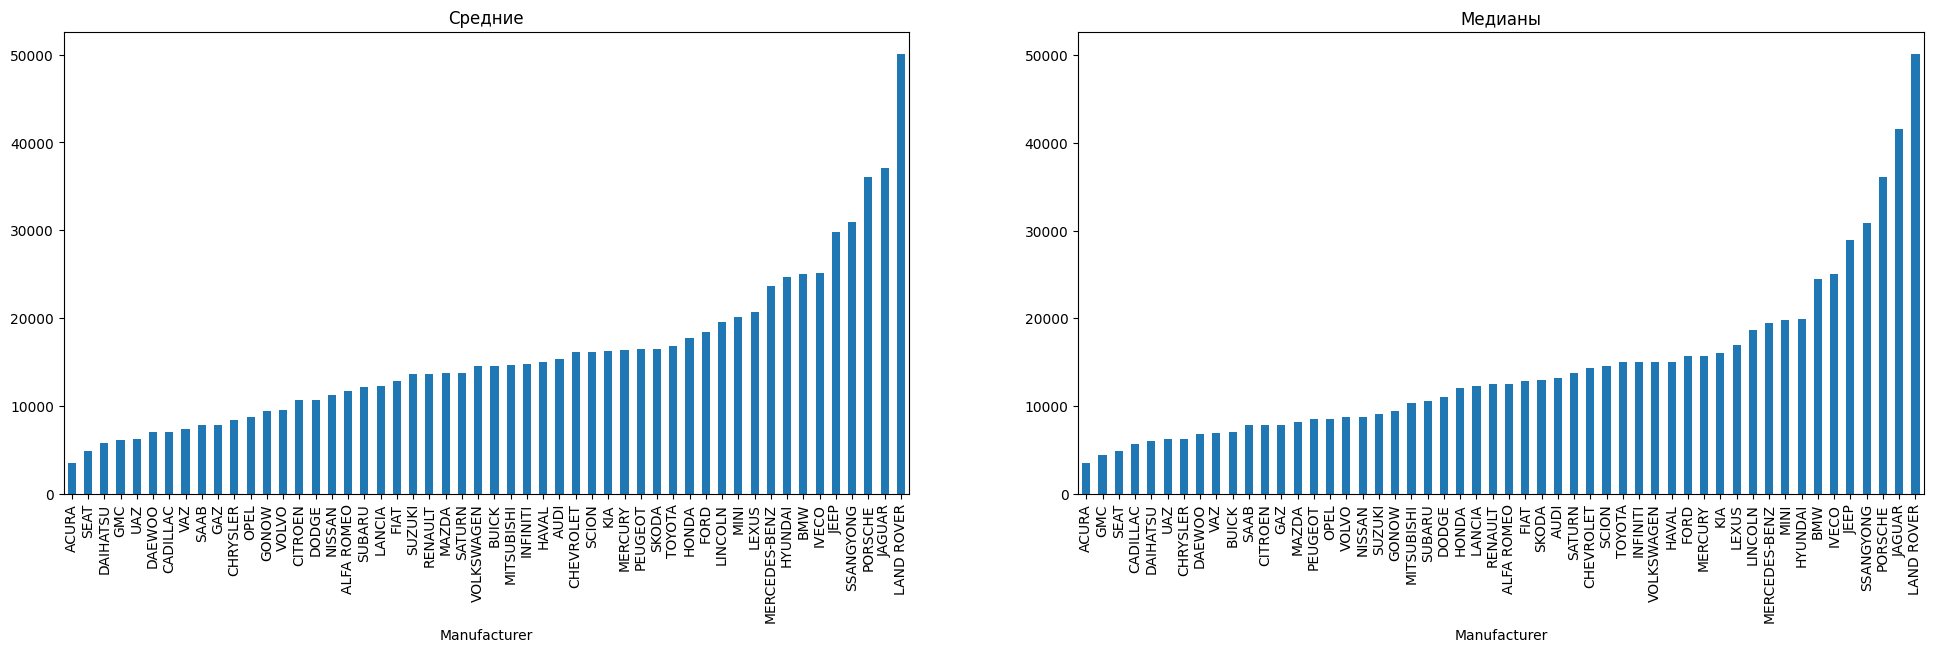

In [29]:
price_by_category(df, "Manufacturer", figsize=(24,6))

### Model(1590)

In [30]:
df["Model"].value_counts()

Model
Elantra          827
Prius            782
Sonata           656
Camry            614
Santa FE         502
                ... 
Transit 350T       1
Octavia Scout      1
Astra GE           1
A4 B6              1
Optima ex          1
Name: count, Length: 934, dtype: int64

### Category(11)

In [31]:
df["Category"].value_counts()

Category
Sedan          5109
Jeep           2728
Hatchback      2105
Minivan         492
Universal       299
Coupe           250
Microbus        149
Goods wagon     149
Pickup           22
Cabriolet         6
Name: count, dtype: int64

,mean,median,count
Category,,,
Cabriolet,29501.833333,17092.0,6
Coupe,19407.168000,15289.0,250
Goods wagon,11140.563758,9722.0,149
Hatchback,13926.127316,12544.0,2105
Jeep,28022.839809,24775.0,2728
Microbus,21264.154362,17876.0,149
Minivan,22247.973577,19441.0,492
Pickup,26286.000000,22260.0,22
Sedan,16702.967704,15367.0,5109


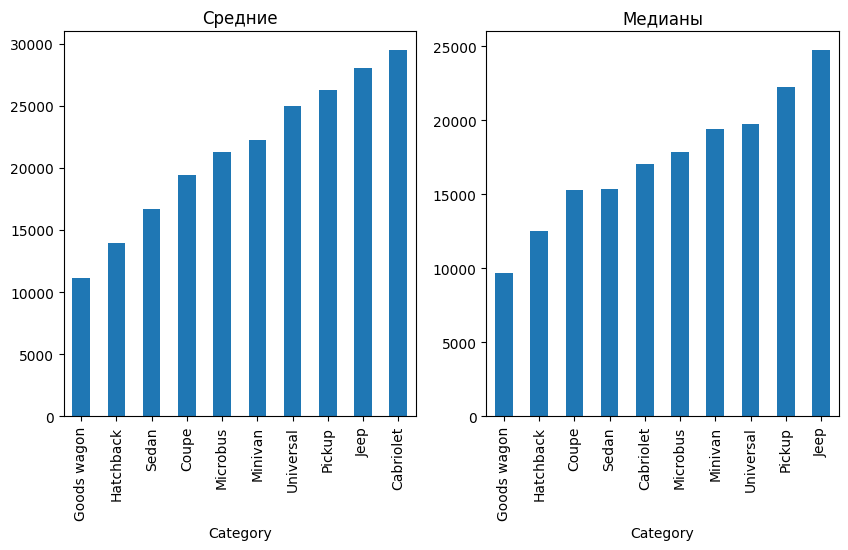

In [32]:
price_by_category(df, "Category", figsize=(10, 5))

### Leather interior: логический

In [33]:
df["Leather interior"].value_counts()

Leather interior
Yes    7764
No     3545
Name: count, dtype: int64

,mean,median,count
Leather interior,,,
No,15216.919323,13485.0,3545
Yes,21379.800876,18189.0,7764


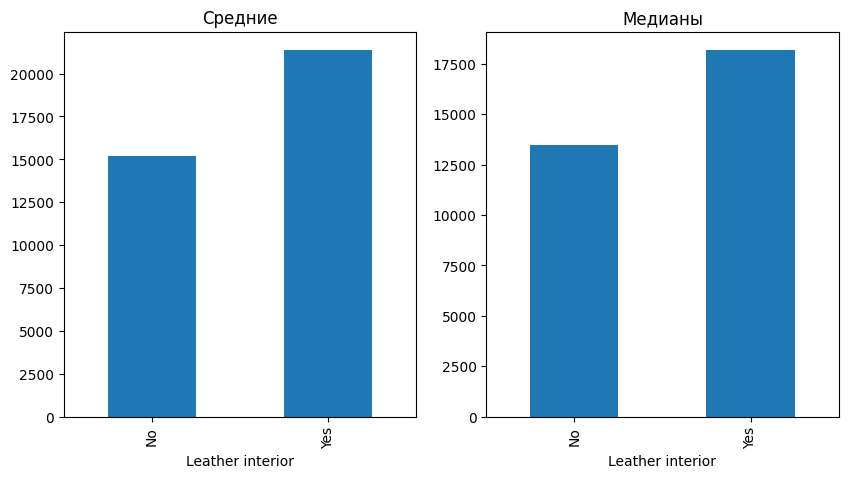

In [34]:
price_by_category(df, "Leather interior", figsize=(10, 5))

### Fuel type(7)

In [35]:
df["Fuel type"].value_counts()

Fuel type
Petrol            5776
Diesel            2691
Hybrid            2194
LPG                442
CNG                123
Plug-in Hybrid      83
Name: count, dtype: int64

,mean,median,count
Fuel type,,,
CNG,8153.560976,7840.0,123
Diesel,27691.687848,24709.0,2691
Hybrid,14129.701914,13201.0,2194
LPG,14839.092760,14740.0,442
Petrol,18159.079467,15423.0,5776
Plug-in Hybrid,23725.843373,22580.0,83


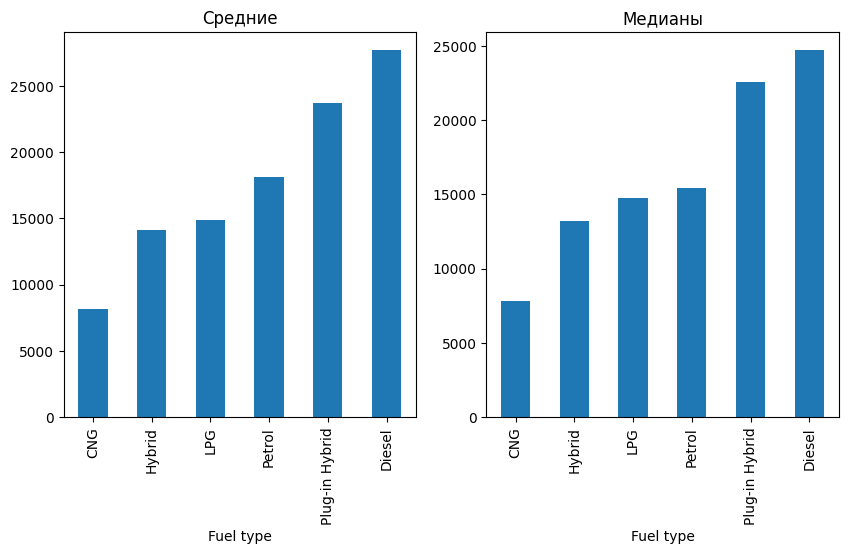

In [36]:
price_by_category(df, "Fuel type", figsize=(10, 5))

### Turbo: логический

In [37]:
df["Turbo"].value_counts()

Turbo
False    10135
True      1174
Name: count, dtype: int64

,mean,median,count
Turbo,,,
False,19180.497780,15693.0,10135
True,21756.735945,18503.0,1174


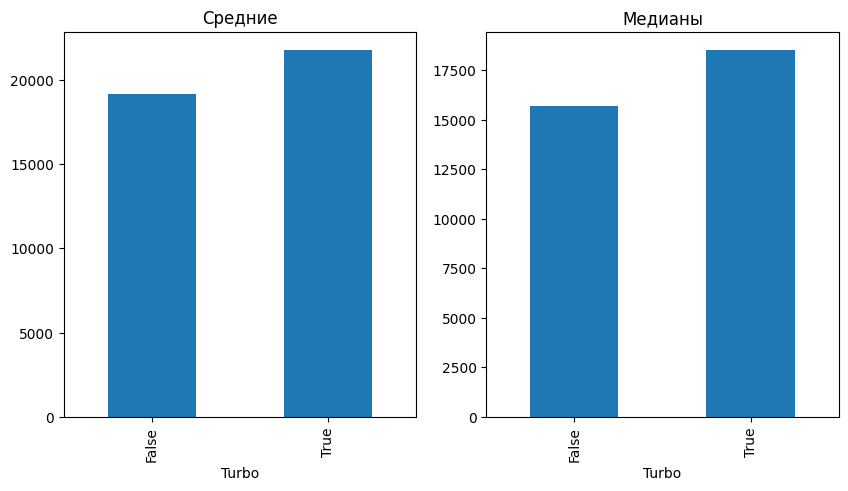

In [38]:
price_by_category(df, "Turbo", figsize=(10, 5))

### Wheel: логический

In [39]:
# criterion_value, p_value = ttest_ind(df[df.Right_hand == 1]["Price"], df[df.Right_hand == 0]["Price"], equal_var=False)
# criterion_value, p_value

In [40]:
df["Wheel"].value_counts()

Wheel
Left wheel          10340
Right-hand drive      969
Name: count, dtype: int64

,mean,median,count
Wheel,,,
Left wheel,20351.959381,17249.0,10340
Right-hand drive,9801.334365,9095.0,969


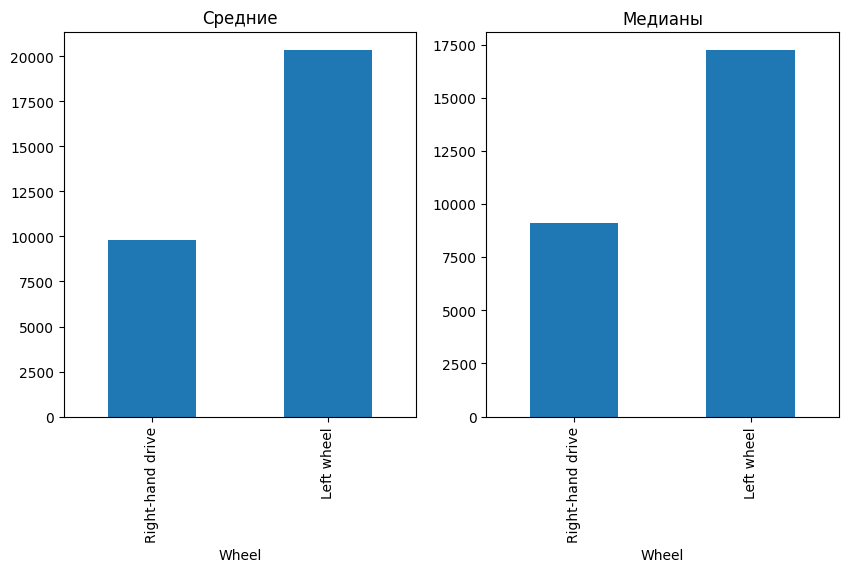

In [41]:
price_by_category(df, "Wheel", figsize=(10, 5))

### Gear box type(4)

In [42]:
df["Gear box type"].value_counts()

Gear box type
Automatic    8174
Tiptronic    1627
Manual        881
Variator      627
Name: count, dtype: int64

,mean,median,count
Gear box type,,,
Automatic,19849.452777,16370.5,8174
Manual,14221.836549,11917.0,881
Tiptronic,21858.061463,18503.0,1627
Variator,15302.746411,14113.0,627


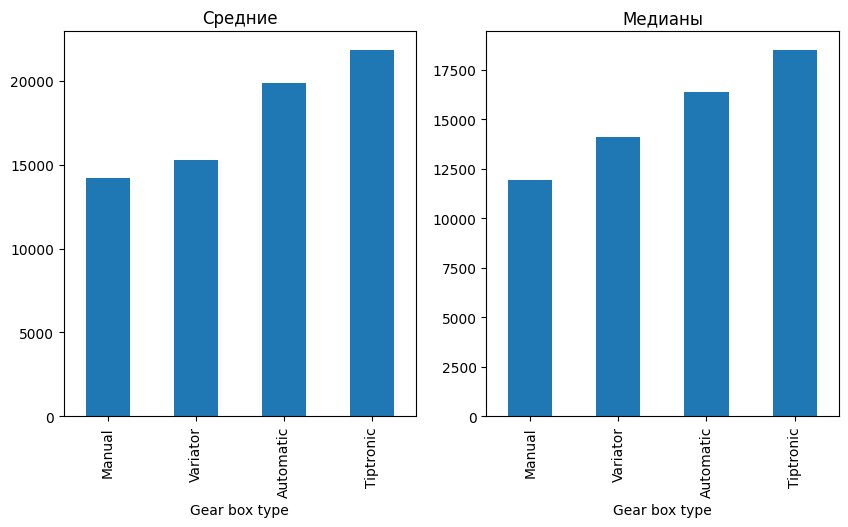

In [43]:
price_by_category(df, "Gear box type", figsize=(10, 5))

### Drive wheels(3)

In [44]:
df["Drive wheels"].value_counts()

Drive wheels
Front    9746
4x4       994
Rear      569
Name: count, dtype: int64

,mean,median,count
Drive wheels,,,
4x4,19643.624748,15210.0,994
Front,19268.961523,16308.0,9746
Rear,22171.688928,19444.0,569


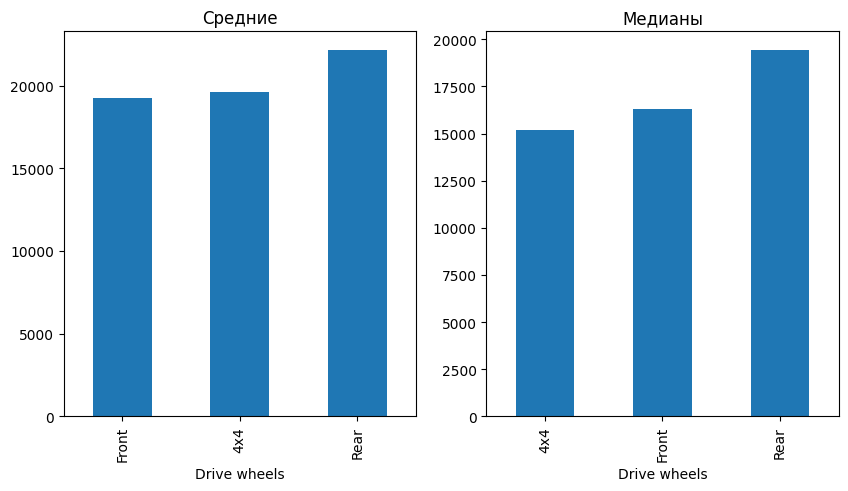

In [45]:
price_by_category(df, "Drive wheels", figsize=(10, 5))

### Doors(3)

In [46]:
df["Doors"].value_counts()

Doors
04-May    10931
02-Mar      315
>5           63
Name: count, dtype: int64

,mean,median,count
Doors,,,
02-Mar,15150.463492,11917.0,315
04-May,19564.213796,16358.0,10931
>5,20760.888889,14113.0,63


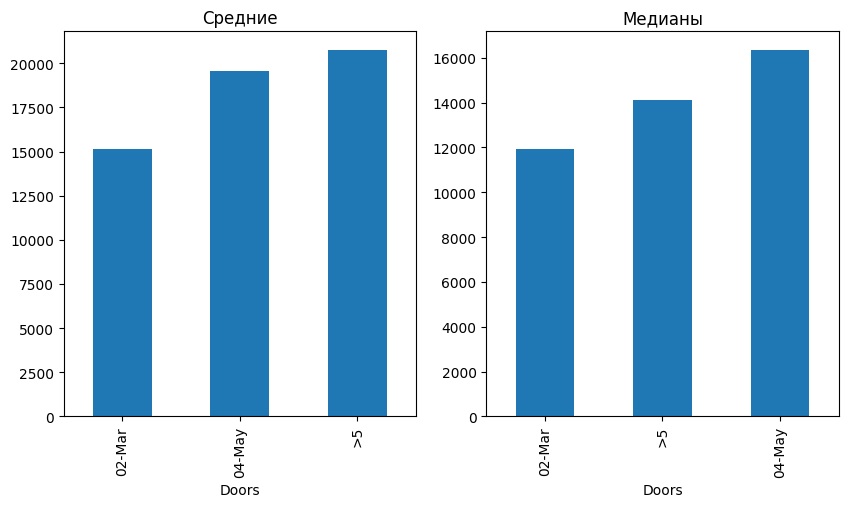

In [47]:
price_by_category(df, "Doors", figsize=(10, 5))

### Color(16)

In [48]:
df["Color"].value_counts()

Color
White            2847
Black            2524
Silver           2440
Grey             1451
Blue              821
Red               424
Green             128
Carnelian red     114
Brown             111
Golden             97
Sky blue           91
Yellow             89
Beige              78
Orange             62
Purple             19
Pink               13
Name: count, dtype: int64

,mean,median,count
Color,,,
Beige,16037.602564,13328.5,78
Black,20322.271395,17125.0,2524
Blue,18353.806334,13799.0,821
Brown,21793.882883,17249.0,111
Carnelian red,17555.728070,16621.0,114
Golden,13884.752577,12858.0,97
Green,13542.382812,11133.0,128
Grey,22321.798759,18503.0,1451
Orange,17603.596774,15994.5,62


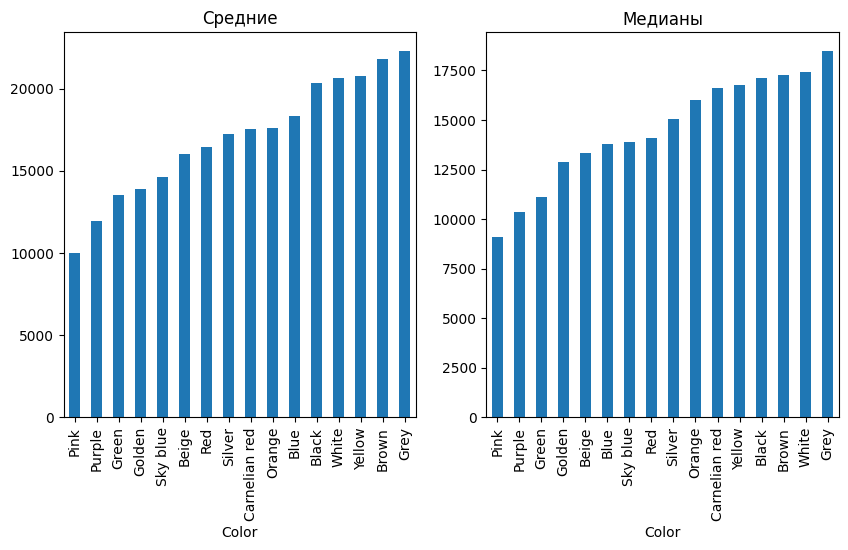

In [49]:
price_by_category(df, "Color", figsize=(10, 5))

# Создание и анализ новых признаков(Edit)

### HasLevy: логический

In [50]:
df["HasLevy"] = df["Levy"] > 0

In [51]:
df["Doors"].value_counts()

Doors
04-May    10931
02-Mar      315
>5           63
Name: count, dtype: int64

,mean,median,count
HasLevy,,,
False,16463.668829,14113.0,2775
True,20418.335130,16935.0,8534


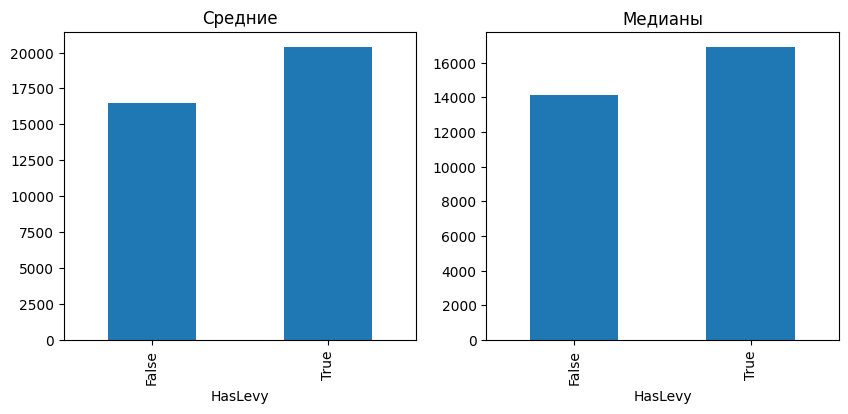

In [52]:
price_by_category(df, "HasLevy", figsize=(10,4))

### Age: численный, непрерывный

In [53]:
df["Age"] = 2024 - df["Prod. year"]

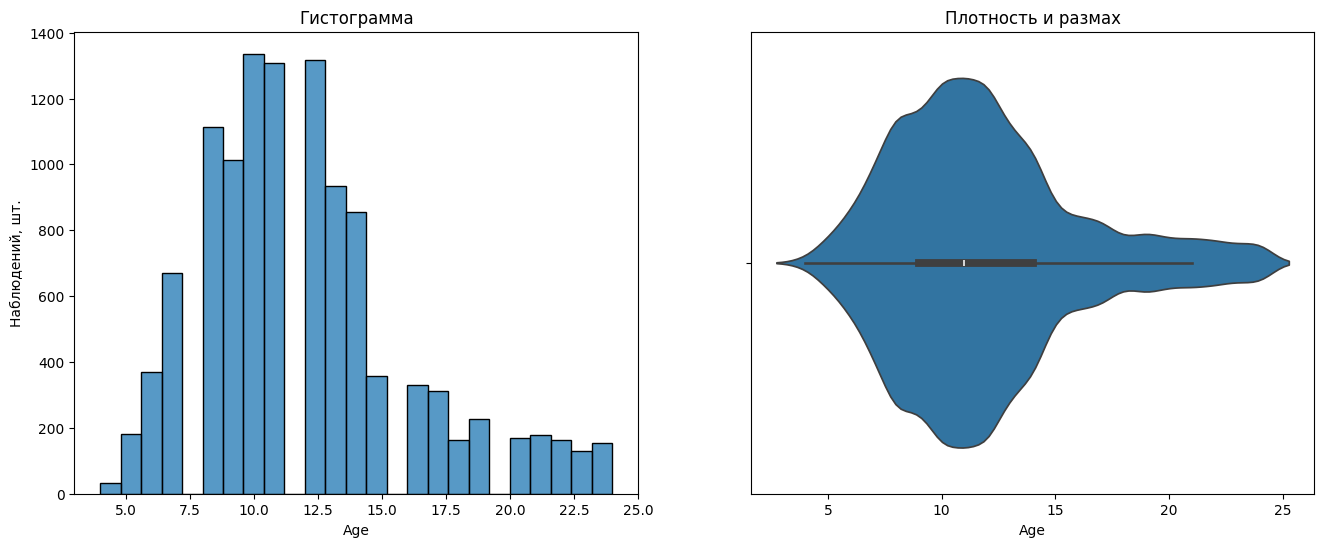

In [54]:
eda_visualize(df["Age"])

### Mileage km/h: численный, непрерывный

In [55]:
df["Mileage km/h"] = df["Mileage"]/((2024 - df["Prod. year"]) * 365 * 12)

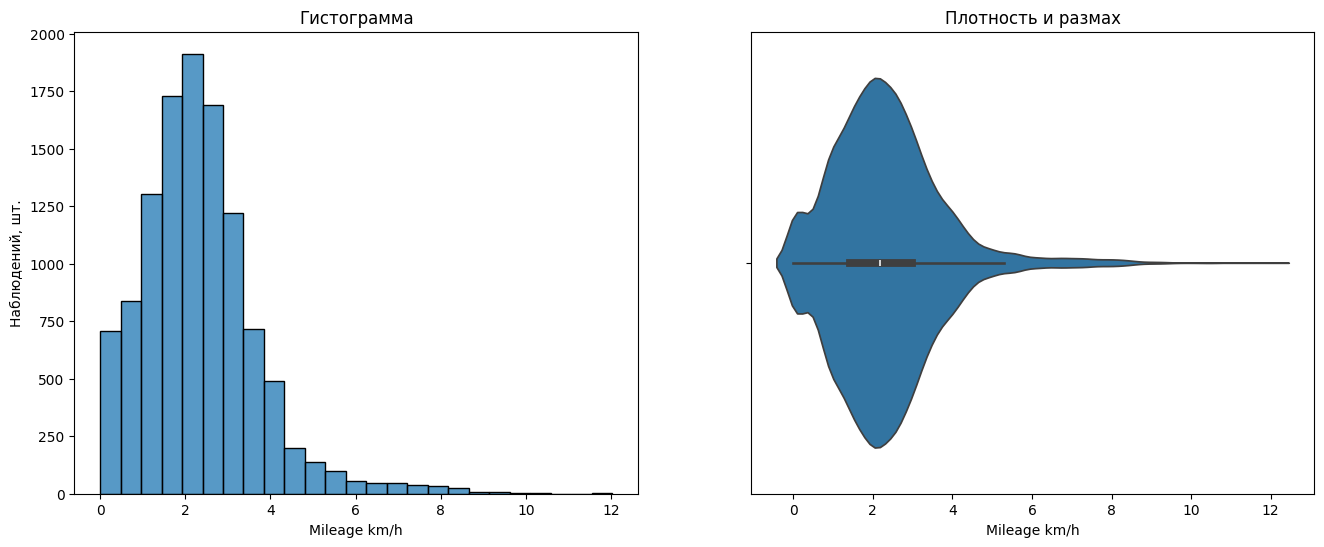

In [56]:
eda_visualize(df["Mileage km/h"])

# Корреляция(Read only)

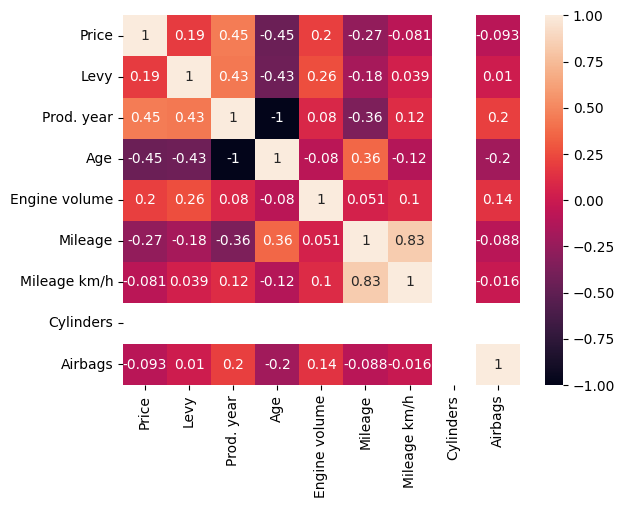

In [57]:
sns.heatmap(df[["Price", "Levy", "Prod. year", "Age", "Engine volume", "Mileage", "Mileage km/h", "Cylinders", "Airbags"]].corr(), annot=True);

# Моделирование(Read Only)

In [58]:
columns_for_ohe_encoding = ['Leather interior', 'Gear box type', 'Drive wheels', 'Doors', 'Wheel']
cols_for_llo_encoding = ["Model", "Manufacturer", "Color", "Fuel type", "Category"]

In [59]:
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(columns=['Price']),
    df["Price"],
    test_size=0.2,
    random_state=79,
    shuffle=True,
)

In [60]:
scaler_list = [
    None,
    MinMaxScaler(),
    StandardScaler(),
    RobustScaler(),
    PowerTransformer(),
    QuantileTransformer(random_state=0),
    QuantileTransformer(random_state=0, output_distribution='normal'),
]

In [88]:
def predict_and_measure(model, params=None):
    if params is None:
        params = {}

    preprocessor = ColumnTransformer(
        transformers=[
            # ('loo_encoder', LeaveOneOutEncoder(), cols_for_llo_encoding),
            ('column_dropper', 'drop', cols_for_llo_encoding),
            ('oh_encoder', OneHotEncoder(drop='first'), columns_for_ohe_encoding),
        ],
        remainder='passthrough',
    )

    pipeline = Pipeline([
        ('encoder', LeaveOneOutEncoder(cols=cols_for_llo_encoding)),
        ('preprocessor', preprocessor),
        ('scaler', StandardScaler()),
        ('model', model),
    ])

    gs = GridSearchCV(
        pipeline,
        params,
        cv=4,
        scoring='neg_mean_squared_error',
        n_jobs=-1,
    )
    gs.fit(X_train, y_train)
    prediction = gs.predict(X_test)

    return (
        gs.best_estimator_,
        mean_squared_error(y_test, prediction),
        mean_absolute_error(y_test, prediction),
        r2_score(y_test, prediction),
    )


## LinearRegression

In [89]:
m, mse, mae, r2 = predict_and_measure(LinearRegression())
mse, mae, r2

(85892995.97787923, 6716.783280693907, 0.5915982795181574)

(84664382.70762542, 6681.036965562508, 0.5974400570422258)

## TweedieRegressor

In [90]:
m, mse, mae, r2 = predict_and_measure(model=TweedieRegressor(power=1, max_iter=2000))
mse, mae, r2

(70842582.31183873, 5893.46505232384, 0.6631595839667456)

(73105662.62084319, 5885.742083839062, 0.6523991502286556)

## Ridge

In [91]:
m, mse, mae, r2 = predict_and_measure(
    model=Ridge(),
    params={"model__alpha": range(1, 10)},
)
mse, mae, r2

(85911933.28695296, 6715.916935873188, 0.5915082369073605)

(84689019.47818509, 6679.560364810826, 0.5973229147843604)

## HistGradientBoosting

In [92]:
m, mse, mae, r2 = predict_and_measure(
    model=HistGradientBoostingRegressor(random_state=79)
)
mse, mae, r2

(158479607.4907498, 9135.286501082923, 0.24646540007548345)

(53734489.749238014, 4844.432900576831, 0.7445046850100037)